In [63]:
import numpy as np
import pandas as pd
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt

## Data Load

In [66]:
bon_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/bonneville/"
tda_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/dalles/"

In [68]:
## Load Bonneville Data
# Manually fixing timezone + extra datapoint

bon_hourly = pd.read_csv(bon_path + "bon-hourlyops.csv")
bon_hourly['Date Time'] = pd.to_datetime(bon_hourly['Date Time'])
bon_hourly['Date Time'] = bon_hourly['Date Time'] + pd.Timedelta(hours=3)
bon_hourly = bon_hourly.iloc[1:].reset_index(drop=True)

bon_hh = pd.read_csv(bon_path + "bon-hhead.csv")

In [70]:
## Load The Dalles Dam Data
# Manually fixing timezone + extra datapoint

tda_hourly = pd.read_csv(tda_path + "tda-hourlyops.csv")
tda_hourly['Date Time'] = pd.to_datetime(tda_hourly['Date Time'])
tda_hourly['Date Time'] = tda_hourly['Date Time'] + pd.Timedelta(hours=3)
tda_hourly = tda_hourly.iloc[1:].reset_index(drop=True)

tda_hh = pd.read_csv(tda_path + "tda-hhead.csv")

In [72]:
has_leap_day = any((tda_hourly['Date Time'].dt.month == 2) & (tda_hourly['Date Time'].dt.day == 29))
print("Leap day present:", has_leap_day)

Leap day present: True


In [74]:
bon_hourly.head(2)

,Date Time,BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft],BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],BON.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs]
0,2022-01-01 00:00:00,74.1,194.6,NaN,198.1
1,2022-01-01 01:00:00,74.2,194.1,185.84,197.6


In [76]:
tda_hourly.tail(1)

,Date Time,TDA.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft],TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],TDA.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],TDA.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs]
26271,2024-12-31 23:00:00,159.33,150.5,NaN,151.7


In [78]:
tda_hourly.head(2)

,Date Time,TDA.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft],TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],TDA.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],TDA.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs]
0,2022-01-01 00:00:00,157.98,203.4,NaN,204.5
1,2022-01-01 01:00:00,158.09,203.7,184.542,204.8


In [80]:
tda_hourly.tail(1)

,Date Time,TDA.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft],TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],TDA.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],TDA.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs]
26271,2024-12-31 23:00:00,159.33,150.5,NaN,151.7


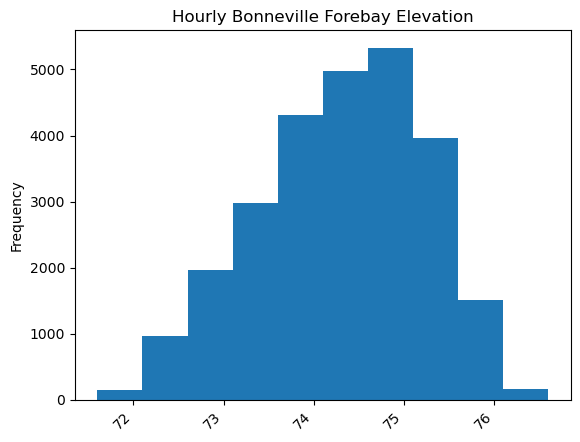

In [82]:
plt.hist(bon_hourly['BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]'])
plt.title('Hourly Bonneville Forebay Elevation')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

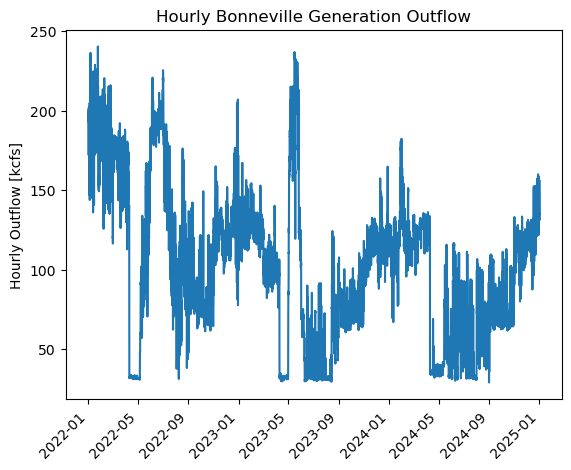

In [84]:
plt.plot(bon_hourly['Date Time'], bon_hourly['BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]'])
plt.title('Hourly Bonneville Generation Outflow')
plt.ylabel('Hourly Outflow [kcfs]')
plt.xticks(rotation=45, ha='right')
plt.show()

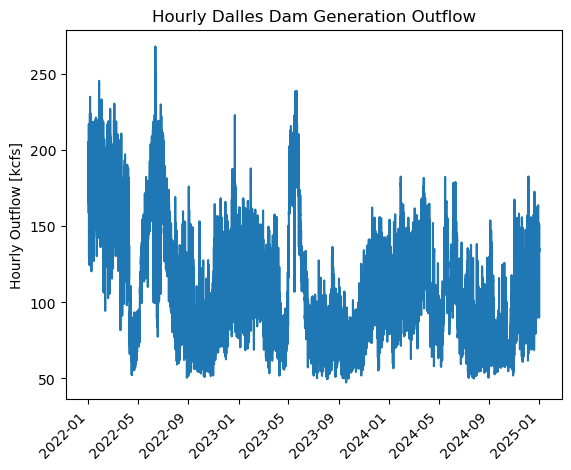

In [86]:
plt.plot(tda_hourly['Date Time'], tda_hourly['TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]'])
plt.title('Hourly Dalles Dam Generation Outflow')
plt.ylabel('Hourly Outflow [kcfs]')
plt.xticks(rotation=45, ha='right')
plt.show()

## Fitting the Hydraulic Head Function

In [91]:
bon_storage_path = bon_path + "BON6S_daily.csv"
tda_storage_path = tda_path + "TDA6S_daily.csv"

In [99]:
bon_storage = pd.read_csv(bon_storage_path)
tda_storage = pd.read_csv(tda_storage_path)

In [165]:
def cfs_to_af(cfs_day):
    """
    Convert 'CFS‑days' to acre‑feet:

    acre‑ft = cfs_day / 1.9835
    """
    return cfs_day / 1.9835 


def af_to_m3(acft):
    """Convert acre‑feet to cubic metres (1 af = 1233.48 m³)."""
    return acft * 1_233.48

def ft_to_m(ft):
    return ft / 3.281


In [107]:
bon_storage = bon_storage.rename(columns={"S (unit:cfs)": "bon_S_cfs"})
bon_storage["bon_S_cumcfs"] = bon_storage["bon_S_cfs"].cumsum()

# cfs‑days → acre‑feet → cubic metres
bon_storage["bon_S_m3"] = af_to_m3(
    cfs_to_af(bon_storage["bon_S_cumcfs"])
)

In [185]:
tda_storage["tda_S_cumcfs"] = tda_storage["S (unit:cfs)"].cumsum()

# cfs‑days → acre‑feet → cubic metres
tda_storage["tda_S_m3"] = af_to_m3(
    cfs_to_af(tda_storage["tda_S_cumcfs"])
)

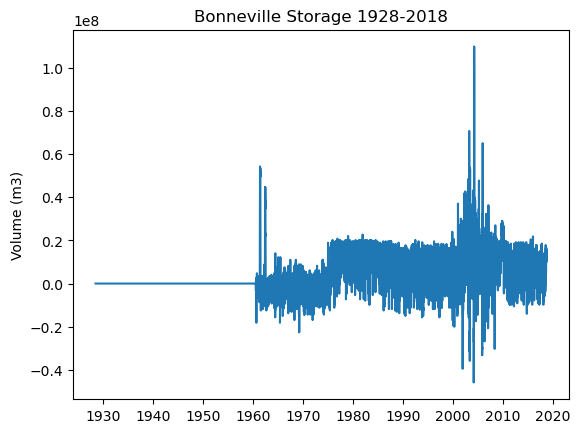

In [145]:
plt.plot(bon_storage.date, bon_storage.bon_S_m3)
plt.title("Bonneville Storage 1928-2018")
plt.ylabel("Volume (m3)")
plt.show()

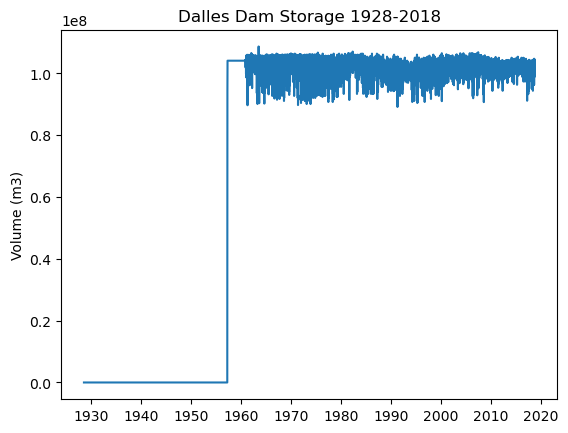

In [205]:
plt.plot(bon_storage.date, tda_storage.tda_S_m3)
plt.title("Dalles Dam Storage 1928-2018")
plt.ylabel("Volume (m3)")
plt.show()

def daily_merge(storage_df, hh_df, storage_date_col, hh_datetime_col, forebay_col, start, end): 

    # Parse dates
    storage = storage_df.copy()
    hh      = hh_df.copy()
    storage[storage_date_col] = pd.to_datetime(storage[storage_date_col])
    hh[hh_datetime_col]       = pd.to_datetime(hh[hh_datetime_col])

    # Compute column-wise daily mean for hourly hh
    hh_daily = (
        hh
        .set_index(hh_datetime_col)
        .resample("D")
        .mean()                      
        .reset_index()
        .rename(columns={hh_datetime_col: storage_date_col})
    )

    # Merge dfs on date column
    merged = pd.merge(
        storage,
        hh_daily,
        on=storage_date_col,
        how="inner"               
    )

    merged = merged.rename(columns={forebay_col: "hh_ft"})
    merged["hh_m"] = ft_to_m(merged.hh_ft)

    # Slice the requested window
    mask = (merged[storage_date_col] >= start) & (merged[storage_date_col] <= end)
    
    return merged.loc[mask].reset_index(drop=True)


### Bonneville Hydraulic Head

In [169]:
bon_hh_merge = daily_merge(
    storage_df=bon_storage,
    hh_df=bon_hh,
    storage_date_col="date",
    hh_datetime_col="Date Time",
    forebay_col = "BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]",
    start="2016-01-01",
    end="2018-12-31",
)

In [171]:
bon_hh_merge.head()

,date,bon_S_cfs,bon_S_cumcfs,bon_S_m3,hh_ft,hh_m
0,2016-01-01,-7411,-886,-5.509772e+05,72.712500,22.161689
1,2016-01-02,-3176,-4062,-2.526038e+06,72.858333,22.206136
2,2016-01-03,1059,-3003,-1.867477e+06,72.508333,22.099462
3,2016-01-04,9529,6526,4.058326e+06,73.320833,22.347099
4,2016-01-05,3176,9702,6.033387e+06,73.350000,22.355989


In [173]:
## Count of negative volume instances

neg_count = (bon_hh_merge["bon_S_m3"] < 0).sum()
neg_count

207

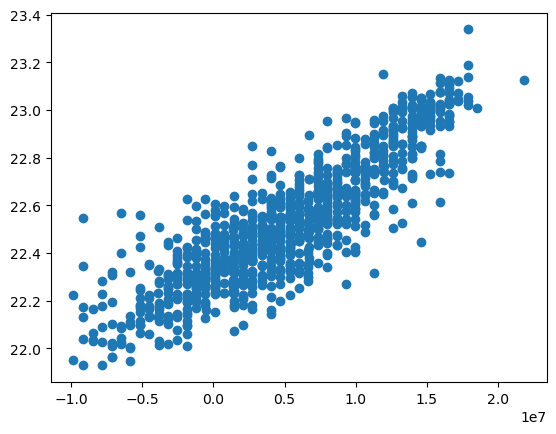

In [215]:
plt.scatter(bon_hh_merge.bon_S_m3, bon_hh_merge.hh_m)
plt.show()

In [427]:
## Filter Data with Volume > 0 into seperate dataset to be fit
storage_col="bon_S_m3"
head_col="hh_m"

bon_hh_neg = bon_hh_merge[bon_hh_merge[storage_col] < 0]
bon_hh_pos = bon_hh_merge[bon_hh_merge[storage_col] >= 0]

In [332]:
bon_hh_pos.head()

,date,bon_S_cfs,bon_S_cumcfs,bon_S_m3,hh_ft,hh_m
3,2016-01-04,9529,6526,4.058326e+06,73.320833,22.347099
4,2016-01-05,3176,9702,6.033387e+06,73.350000,22.355989
5,2016-01-06,-4235,5467,3.399766e+06,73.883333,22.518541
6,2016-01-07,1059,6526,4.058326e+06,73.808333,22.495682
7,2016-01-08,3176,9702,6.033387e+06,73.845833,22.507112


In [431]:
## Apply OLS to positive subset 
import statsmodels.api as sm
from scipy.optimize import curve_fit

X = sm.add_constant(np.log(bon_hh_pos[storage_col]))     # adds intercept = log a
y = np.log(bon_hh_pos[head_col])

ols = sm.OLS(y, X).fit()
log_a, bon_b = ols.params
bon_a = np.exp(log_a)

print(f"OLS result:  a = {bon_a:.4g},  b = {bon_b:.4g}")

OLS result:  a = 20.68,  b = 0.00578


In [433]:
def predict_head(V, a, b):
    return a * (V)**b

In [453]:
def hh_plot(pos_df, neg_df, storage_col, head_col, min_oper_level, max_oper_level, a_param, b_param):

    figsize = (10, 3)

    # Plot Characteristics
    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(
        pos_df[storage_col], pos_df[head_col],
        alpha=0.8, color="tab:blue", label=f"Volume [m3] ≥ 0"
    )
    
    if neg_df is not None:
        ax.scatter(
            neg_df[storage_col], neg_df[head_col],
            alpha=0.25, color="lightskyblue", label=f"Volume [m3] < 0"
        )

    eqn_label = rf"$h(t) = {a_param:.2g}\,V(t)^{{{b_param:.1g}}}$"  
    ax.plot(
        x_line,
        pred_head,
        color="red",
        linewidth=2.0,
        label=eqn_label 
    )

    ax.axhline(min_oper_level, color="orange",  ls="--",
               label="Minumum Forebay [m]")
    ax.axhline(max_oper_level, color="orange",    ls="--",
               label="Maximum Forebay [m]")
    
    ax.set_ylabel("Avg. Daily Forebay Elevation [m]")
    ax.set_xlabel("Daily Reservoir Volume [m3]")
    ax.set_title(f"Reservoir Volume over Forebay Elevation")
    ax.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", frameon=False)
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

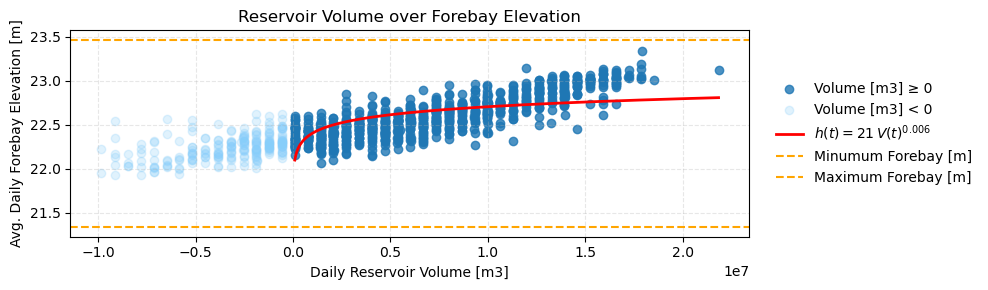

In [459]:
storage_col="bon_S_m3"
head_col="hh_m"


x_line = np.linspace(
    bon_hh_pos[storage_col].clip(lower=0).min(),    # start at smallest non‑negative V
    bon_hh_pos[storage_col].max(),                  # end at max V in the data
    400                                     # smoothness
)

pred_head = predict_head(x_line, a=20.68, b=0.0058)

# Scatter each set seperately 
hh_plot(
    pos_df=bon_hh_pos,
    neg_df = bon_hh_neg,
    storage_col=storage_col,
    head_col=head_col, 
    min_oper_level = ft_to_m(70),
    max_oper_level = ft_to_m(77),
    a_param = bon_a, 
    b_param = bon_b
)

## Dalles Dam Hydrualic Head

In [439]:
tda_hh_merge = daily_merge(
    storage_df=tda_storage,
    hh_df=tda_hh,
    storage_date_col="date",
    hh_datetime_col="Date Time",
    forebay_col = "TDA.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]",
    start="2016-01-01",
    end="2018-12-31",
)

In [441]:
tda_hh_merge.head()

,date,S (unit:cfs),tda_S_cumcfs,tda_S_m3,hh_ft,hh_m
0,2016-01-01,0,166817,1.037386e+08,159.247500,48.536269
1,2016-01-02,519,167336,1.040613e+08,159.107083,48.493473
2,2016-01-03,-2284,165052,1.026410e+08,159.003750,48.461978
3,2016-01-04,1170,166222,1.033685e+08,158.910417,48.433531
4,2016-01-05,-565,165657,1.030172e+08,159.263750,48.541222


In [443]:
## Count of negative volume instances

neg_count = (tda_hh_merge["tda_S_m3"] < 0).sum()
neg_count

0

In [461]:
storage_col="tda_S_m3"

In [463]:
## Apply OLS  
X = sm.add_constant(np.log(tda_hh_merge[storage_col]))     # adds intercept = log a
y = np.log(tda_hh_merge[head_col])

ols = sm.OLS(y, X).fit()
log_a, tda_b = ols.params
tda_a = np.exp(log_a)

print(f"OLS result:  a = {a:.4g},  b = {b:.4g}")

OLS result:  a = 4.086,  b = 0.134


In [467]:
predict_head(1e8, tda_a, tda_b)

48.25880956110081

In [471]:
1.0141836111923368e8**tda_b

11.833924697857771

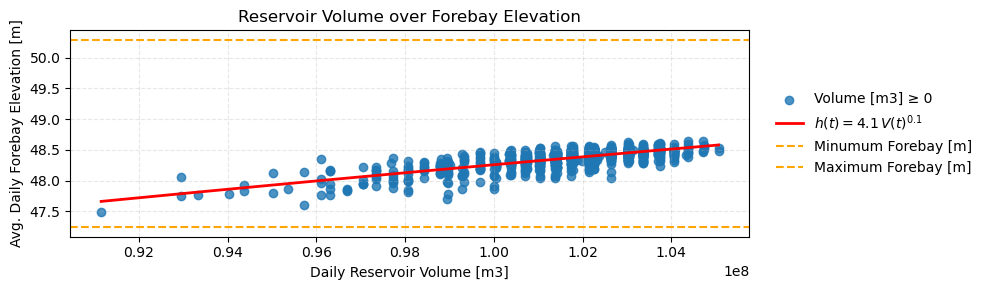

In [465]:
x_line = np.linspace(
    tda_hh_merge[storage_col].min(),    
    tda_hh_merge[storage_col].max(),                 
    400                                     
)

pred_head = predict_head(x_line, tda_a, tda_b)

# Scatter each set seperately 
hh_plot(
    pos_df=tda_hh_merge,
    neg_df = None,
    storage_col=storage_col,
    head_col=head_col, 
    min_oper_level = ft_to_m(155),
    max_oper_level = ft_to_m(165),
    a_param = tda_a, 
    b_param = tda_b
)

## Interpolating Daily Inflow Data

### Identifying Missing Data

In [30]:
full_range = pd.date_range(start=tda_hourly['Date Time'].min(),
                           end=tda_hourly['Date Time'].max(),
                           freq='h')  # for hourly data

In [32]:
has_leap_day = any((full_range.month == 2) & (full_range.day == 29))
print("Leap day present:", has_leap_day)

Leap day present: True


In [34]:
len(full_range)

26304

In [36]:
len(tda_hourly)

26272

In [38]:
len(full_range) - len(tda_hourly)

32

In [40]:
# Convert to sets for fast comparison
actual_timestamps = set(tda_hourly['Date Time'])
expected_timestamps = set(full_range)

missing_timestamps = sorted(expected_timestamps - actual_timestamps)

In [42]:
missing_timestamps

[Timestamp('2022-06-07 12:00:00'),
 Timestamp('2022-06-13 21:00:00'),
 Timestamp('2022-06-14 00:00:00'),
 Timestamp('2022-06-14 02:00:00'),
 Timestamp('2022-06-20 20:00:00'),
 Timestamp('2022-06-21 09:00:00'),
 Timestamp('2022-06-22 11:00:00'),
 Timestamp('2022-06-23 00:00:00'),
 Timestamp('2022-06-30 15:00:00'),
 Timestamp('2022-11-09 20:00:00'),
 Timestamp('2022-11-09 21:00:00'),
 Timestamp('2022-11-09 22:00:00'),
 Timestamp('2022-11-09 23:00:00'),
 Timestamp('2022-11-10 00:00:00'),
 Timestamp('2022-11-10 02:00:00'),
 Timestamp('2022-11-10 04:00:00'),
 Timestamp('2022-11-10 05:00:00'),
 Timestamp('2022-11-10 06:00:00'),
 Timestamp('2022-11-10 08:00:00'),
 Timestamp('2022-11-10 10:00:00'),
 Timestamp('2022-11-10 11:00:00'),
 Timestamp('2022-11-10 12:00:00'),
 Timestamp('2022-11-10 15:00:00'),
 Timestamp('2022-11-10 16:00:00'),
 Timestamp('2022-11-10 17:00:00'),
 Timestamp('2022-11-10 18:00:00'),
 Timestamp('2022-11-10 20:00:00'),
 Timestamp('2023-10-14 20:00:00'),
 Timestamp('2023-10-

### Interpolation

In [45]:
tda = tda_hourly.copy()

In [47]:
tda = tda.rename(columns={"TDA.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs]": 'inflow_kcfs'})
tda = tda.rename(columns={"Date Time": 'datetime'})
tda = tda[['datetime', 'inflow_kcfs']]

In [49]:
missing_df = pd.DataFrame(index=missing_timestamps, columns=['inflow_kcfs'])
missing_df = missing_df.reset_index().rename(columns={'index': 'datetime'})

In [51]:
tda = pd.concat([tda, missing_df])

/var/folders/w1/xfz4_86j0zg0zz10g620bhz00000gn/T/ipykernel_79014/2196797759.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tda = pd.concat([tda, missing_df])


In [53]:
# Resort tda dataframe based on datetime column to fix imputed data
tda.sort_values("datetime", ascending=True, inplace=True)  

In [55]:
tda = tda.reset_index(drop=True)

In [57]:
# Fill Forwards with last collection point
tda['inflow_kcfs'] = tda['inflow_kcfs'].ffill()

In [59]:
# Fill Backwards for first time step 
tda['inflow_kcfs'] = tda['inflow_kcfs'].bfill()

In [61]:
save_path = "/Users/elizacohn/Desktop/cascaded-hydro/simulation-data/tda-inflow-USACE.csv"
tda.to_csv(save_path, index=False)

In [167]:
len(tda)

26304

In [169]:
tda.tail()

,datetime,inflow_kcfs
26299,2024-12-31 19:00:00,152.653
26300,2024-12-31 20:00:00,152.653
26301,2024-12-31 21:00:00,152.653
26302,2024-12-31 22:00:00,152.653
26303,2024-12-31 23:00:00,152.653


In [171]:
tda.isna().sum()

datetime       0
inflow_kcfs    0
dtype: int64

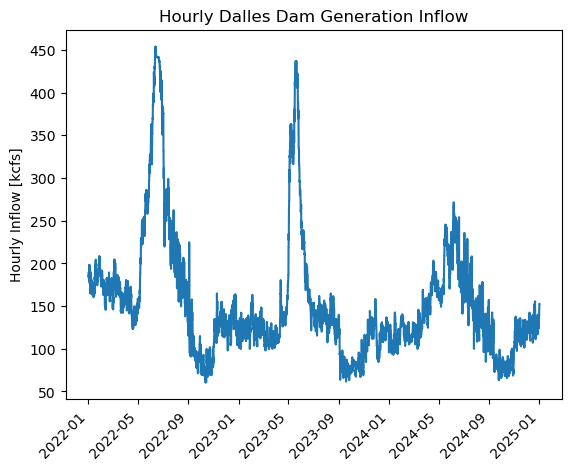

In [183]:
plt.plot(tda['datetime'], tda['inflow_kcfs'])
plt.title('Hourly Dalles Dam Generation Inflow')
plt.ylabel('Hourly Inflow [kcfs]')
plt.xticks(rotation=45, ha='right')
plt.show()

## Calculate Ramp Rate & Release Rate Constraint

In [35]:
def ramp_rate(df, flow_col):

    # Assume df is sorted by time and looks like:
    # df['Date Time']: datetime64[ns]
    # df['Release']: float
    
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    
    # Calculate time difference in hours
    df['Time_Diff_hrs'] = df['Date Time'].diff().dt.total_seconds() / 3600
    
    # Calculate flow difference
    df['Flow_Diff'] = df[flow_col].diff()
    
    # Compute ramp rate (cfs per hour)
    df['Ramp_Rate'] = df['Flow_Diff'] / df['Time_Diff_hrs']

    return df

In [36]:
def plot_hist_with_quantiles(
    df, site, type, column, lower_q, upper_q, bins=50
):
    """
    Plots a histogram of a column with two quantile lines.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): Column name to plot.
        lower_q (float): Lower quantile (e.g., 0.25).
        upper_q (float): Upper quantile (e.g., 0.75).
        bins (int): Number of histogram bins.
    """
    
    # Drop NA values
    data = df[column].dropna()

    # Compute quantiles
    q_low = data.quantile(lower_q)
    q_high = data.quantile(upper_q)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.7)

    # Plot quantile lines
    for q, label in zip(
        [q_low, q_high],
        [f'{int(lower_q * 100)}th percentile: {q_low:.2f}', f'{int(upper_q * 100)}th percentile: {q_high:.2f}']
    ):
        plt.axvline(q, color='red', linestyle='--', linewidth=1.5, label=label)

    # Formatting
    plt.xlabel(column)
    plt.ylabel('Frequency')
    # plt.xlim([-30, 30])
    plt.title(f'Histogram of {site} {type} with Quantiles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [37]:
bon_hourly = ramp_rate(bon_hourly, 'BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]')

In [81]:
bon_hourly.head()

,Date Time,BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft],BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],BON.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs],Time_Diff_hrs,Flow_Diff,Ramp_Rate
0,2022-01-01 00:00:00,74.1,194.6,NaN,198.1,NaN,NaN,NaN
1,2022-01-01 01:00:00,74.2,194.1,185.84,197.6,1.0,-0.5,-0.5
2,2022-01-01 02:00:00,74.3,194.7,NaN,198.2,1.0,0.6,0.6
3,2022-01-01 03:00:00,74.3,194.3,NaN,197.8,1.0,-0.4,-0.4
4,2022-01-01 04:00:00,74.3,193.2,NaN,196.7,1.0,-1.1,-1.1


In [38]:
tda_hourly = ramp_rate(tda_hourly, 'TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]')

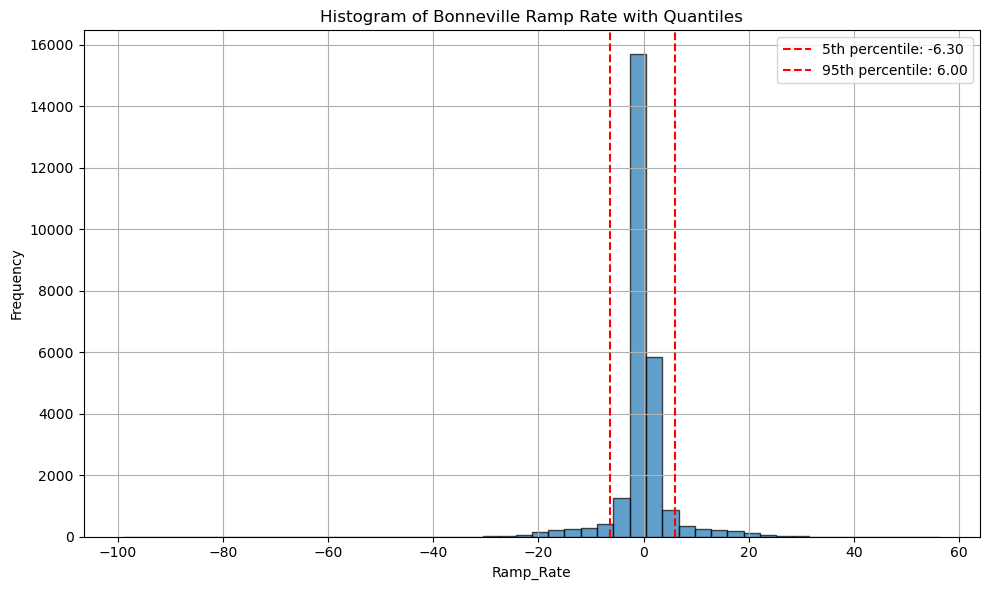

In [39]:
plot_hist_with_quantiles(bon_hourly, 'Bonneville', 'Ramp Rate', 'Ramp_Rate', lower_q=0.05, upper_q=0.95)

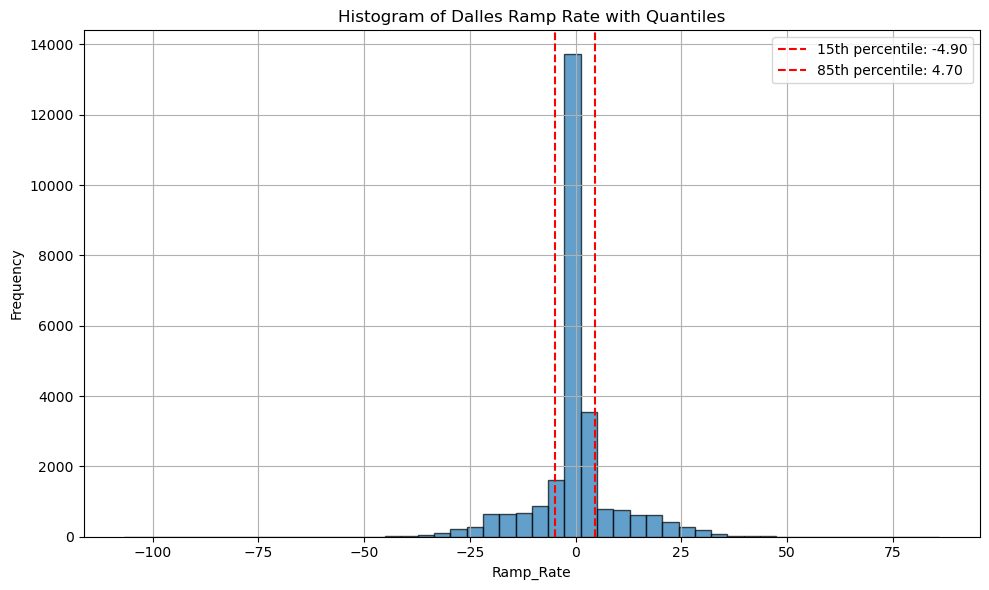

In [40]:
plot_hist_with_quantiles(tda_hourly, 'Dalles', 'Ramp Rate', 'Ramp_Rate', lower_q=0.15, upper_q=0.85)

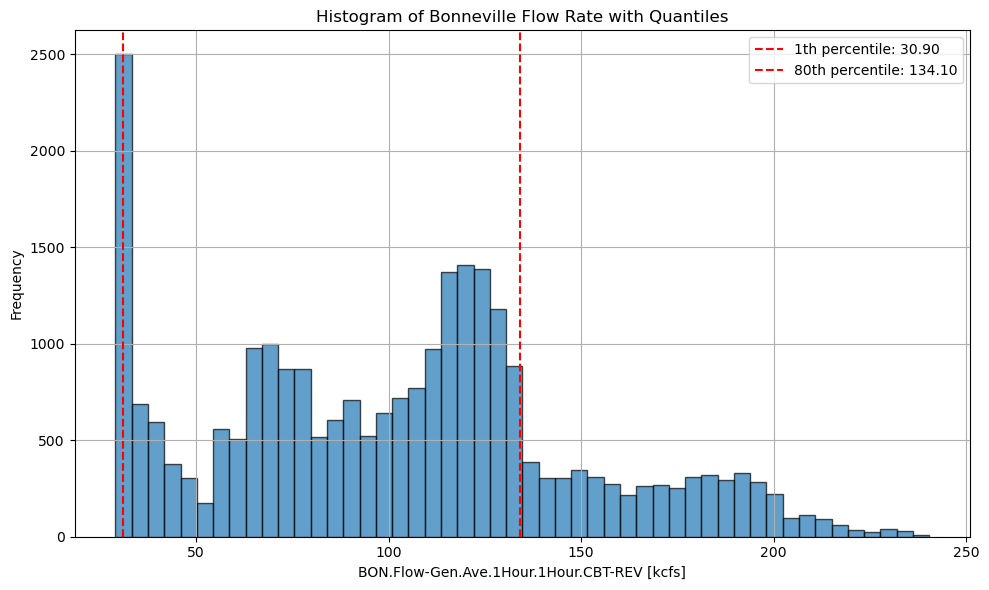

In [41]:
plot_hist_with_quantiles(bon_hourly, 'Bonneville', 'Flow Rate', 'BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]', lower_q=0.01, upper_q=0.80)

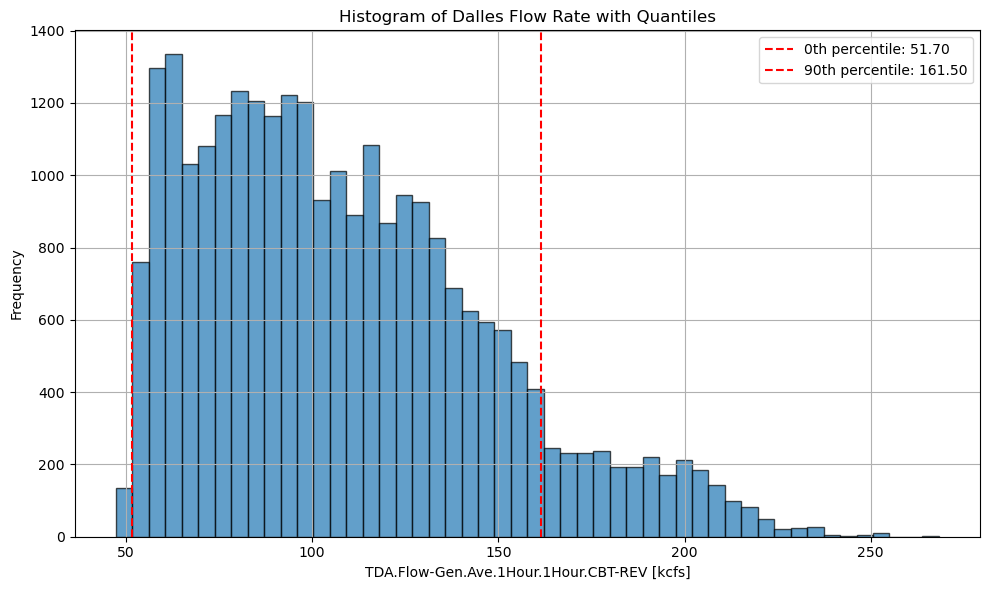

In [42]:
plot_hist_with_quantiles(tda_hourly, 'Dalles', 'Flow Rate', 'TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]', lower_q=0.005, upper_q=0.90)